In [2]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pickle

In [3]:
N = 20

def cat_factory(n, alpha=1):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)
    
    return cat_n / cat_n.norm()

def cat_dm_factory(n, alpha=1):
    return cat_factory(n, alpha=alpha).todm()

def plot_wigner(xvals, yvals, wigner_values):
    plt.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
    plt.colorbar()

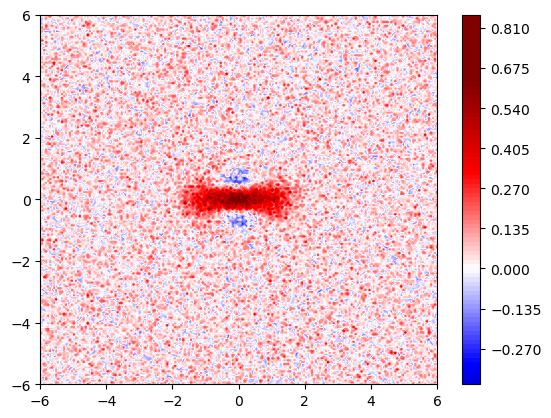

In [164]:
state = cat_factory(2)
xvec, yvec, wigner = dq.wigner(state)

a = 1.
b = 0
sigma = 0.1
noise = np.random.normal(0.0, scale=sigma, size=wigner.shape)

wigner_noisy = a*wigner + b*np.ones_like(wigner) + noise

plot_wigner(xvec, yvec, wigner_noisy)






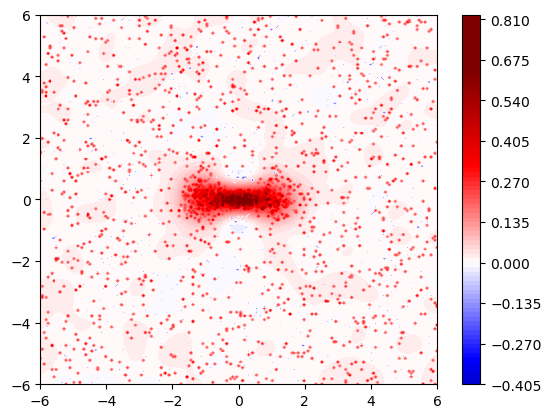

In [28]:
import numpy as np
from scipy.ndimage import gaussian_filter

# your existing data
# xvec, yvec, wigner = dq.wigner(state)
# wigner_noisy = a*wigner + b*np.ones_like(wigner) + noise

# 1. choose a threshold: anything smaller in magnitude is "background"
threshold = 0.2

# 2. make a heavily‐smoothed version of the noisy data
#    (sigma=5 is just a starting point; increase for more aggressive smoothing)
smooth_heavy = gaussian_filter(wigner_noisy, sigma=5)

# 3. build a mask for low‐value regions
mask_low = np.abs(wigner_noisy) < threshold

# 4. hybrid—keep original where |W| is large, use smooth_heavy where it's small
wigner_denoised = wigner_noisy.copy()
wigner_denoised_np=np.array(wigner_denoised)
wigner_denoised_np[mask_low] = smooth_heavy[mask_low]

# 5. plot the result
plot_wigner(xvec, yvec, wigner_denoised_np)

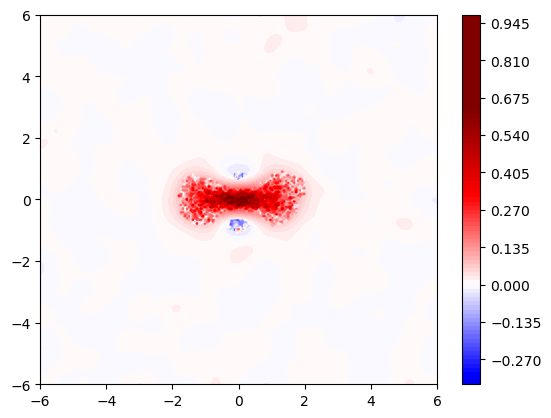

In [160]:
import numpy as np
from scipy.ndimage import gaussian_filter, uniform_filter

# assume wigner_noisy is your 2D array

# 1. build binary masks of positive and negative
pos_mask = (wigner_noisy > 0).astype(float)
neg_mask = (wigner_noisy < 0).astype(float)

# 2. choose a window size (in pixels) over which to look for clusters
win = 11   # e.g. 11×11 neighborhood

# 3. compute local counts (actually local fractions) of positives/negatives
# uniform_filter sums (here since mask is 0/1, it gives count) then we normalize by total window size
local_pos_frac = uniform_filter(pos_mask, size=win)
local_neg_frac = uniform_filter(neg_mask, size=win)

# 4. define your cluster thresholds
# for instance, if more than 50% of the window is positive (resp. negative):
thr = 0.3

cluster_mask = (local_pos_frac > thr) & (local_neg_frac > thr)

# 5. make a heavily‐smoothed version of the whole noisy Wigner
smooth_heavy = gaussian_filter(wigner_noisy, sigma=5)

# 6. combine: apply the heavy smooth only inside clusters
wigner_denoised = wigner_noisy.copy()
wigner_denoised_np=np.array(wigner_denoised)
wigner_denoised_np[cluster_mask] = smooth_heavy[cluster_mask]

# 7. plot
plot_wigner(xvec, yvec, wigner_denoised_np)

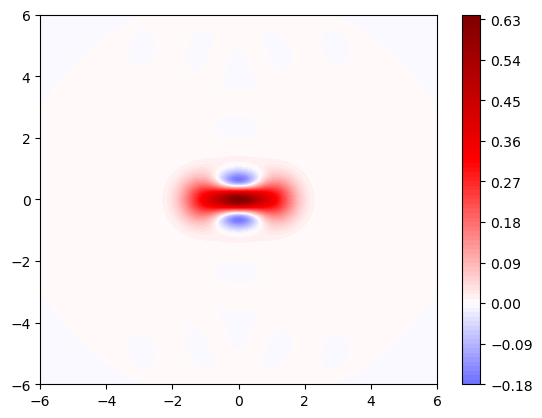

In [42]:
plot_wigner(xvec, yvec, wigner)

In [165]:
import numpy as np
from scipy.ndimage import uniform_filter

# assume wigner_noisy is your 2D array

# 1. compute local mean of W and local mean of W² over a small window
win = 10                          # size of the patch in pixels
mean1 = uniform_filter(wigner_noisy, size=win)
mean2 = uniform_filter(wigner_noisy**2, size=win)

# 2. estimate the local variance: Var = E[W²] – (E[W])²
local_var = mean2 - mean1**2

# 3. pick a threshold for “flatness” (tune this)
var_thr = np.percentile(local_var, 5)  
# e.g. take the bottom 5% of variances

# 4. build a mask of flat regions
flat_mask = local_var <= var_thr

# 5. estimate b by averaging wigner_noisy over all flat pixels
b_est = np.mean(wigner_noisy[flat_mask])

print("Estimated offset b =", b_est)

Estimated offset b = 0.0013468617


In [ ]:
def compute_offset(wigner_noisy):
    # 1. compute local mean of W and local mean of W² over a small window
    win = 10                          # size of the patch in pixels
    mean1 = uniform_filter(wigner_noisy, size=win)
    mean2 = uniform_filter(wigner_noisy**2, size=win)

    # 2. estimate the local variance: Var = E[W²] – (E[W])²
    local_var = mean2 - mean1**2

    # 3. pick a threshold for “flatness” (tune this)
    var_thr = np.percentile(local_var, 5)  
    # e.g. take the bottom 5% of variances

    # 4. build a mask of flat regions
    flat_mask = local_var <= var_thr

    # 5. estimate b by averaging wigner_noisy over all flat pixels
    b_est = np.mean(wigner_noisy[flat_mask])
    return b_est


def generate_noisy_cat(sigma):
    state = cat_factory(2)
    xvec, yvec, wigner = dq.wigner(state)

    a = 1.
    b = 0.5
    sigma = sigma
    noise = np.random.normal(0.0, scale=sigma, size=wigner.shape)

    wigner_noisy = a*wigner + b*np.ones_like(wigner) + noise
    return wigner_noisy

def rescale_wigner_whole_integral(wigner_noisy_offsetted):
    integral=np.sum(wigner_noisy_offsetted)/wigner_noisy_offsetted.shape[0]**2*12**2
    wigner_noisy_corrected=wigner_noisy_offsetted/integral
    return wigner_noisy_corrected

def rescale_wigner_selected_integral(wigner_noisy_offsetted)
    relevant_mask=np.logical_not(cluster_mask)
    relevant_mask_true_values=relevant_mask.sum()
    integral=np.sum(wigner_noisy_offsetted[relevant_mask])/wigner_noisy_offsetted.shape[0]**2*12**2
    integral


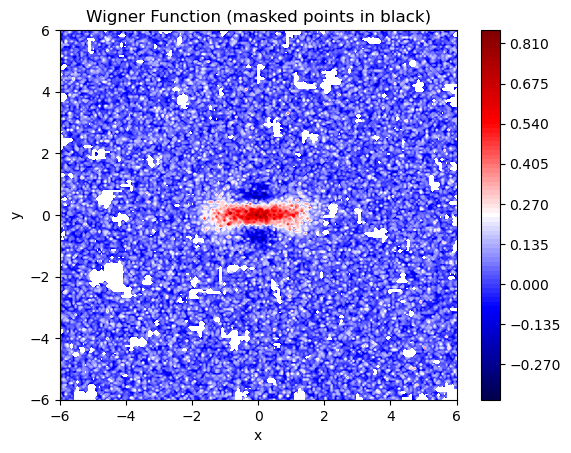

In [ ]:
"""wigner_noisy_np=np.array(wigner_noisy)
wigner_noisy_np[flat_mask]=1
plot_wigner(xvec, yvec, wigner_noisy_np)"""

"""wigner_noisy_np=np.array(wigner_noisy)
masked_data = np.ma.masked_array(wigner_noisy_np, mask=flat_mask)
cmap = plt.cm.seismic.copy()
cmap.set_bad(color='b')
contour = plt.contourf(xvec, yvec, masked_data.T, levels=100, cmap=cmap)"""

# 1) Prepare data & mask
wigner_noisy_np = np.array(wigner_noisy)
mask_2d         = flat_mask.reshape(wigner_noisy_np.shape)
masked_data     = np.ma.masked_array(wigner_noisy_np, mask=mask_2d)

# 2) Customize colormap bad color
cmap = plt.cm.seismic.copy()
cmap.set_bad(color='b')

# 3) Meshgrid for contourf
X, Y = np.meshgrid(xvec, yvec)

# 4) Plot
plt.contourf(X, Y, masked_data.T, levels=100, cmap=cmap, origin='lower')
plt.colorbar()
plt.title('Wigner Function (masked points in black)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

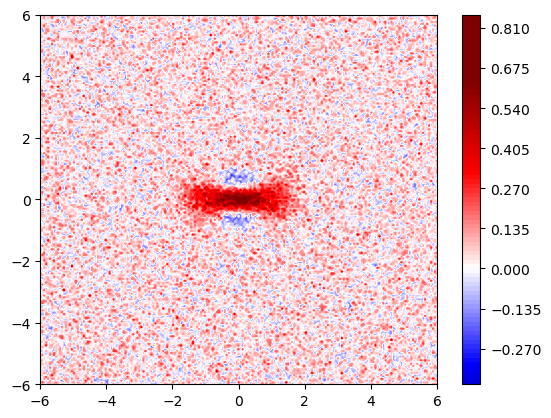

In [154]:
wigner_noisy_offsetted=wigner_noisy-b_est
plot_wigner(xvec, yvec, wigner_noisy_offsetted)

In [142]:
integral=np.sum(wigner_noisy_offsetted)/wigner_noisy_offsetted.shape[0]**2*12**2
wigner_noisy_corrected=wigner_noisy_offsetted/integral
integral

Array(0.98957163, dtype=float32)

In [143]:
relevant_mask=np.logical_not(cluster_mask)
relevant_mask_true_values=relevant_mask.sum()
integral=np.sum(wigner_noisy_offsetted[relevant_mask])/wigner_noisy_offsetted.shape[0]**2*12**2
integral

Array(0.93341535, dtype=float32)

In [44]:
integral=np.sum(wigner)/wigner.shape[0]**2*12**2
integral

Array(0.9900737, dtype=float32)

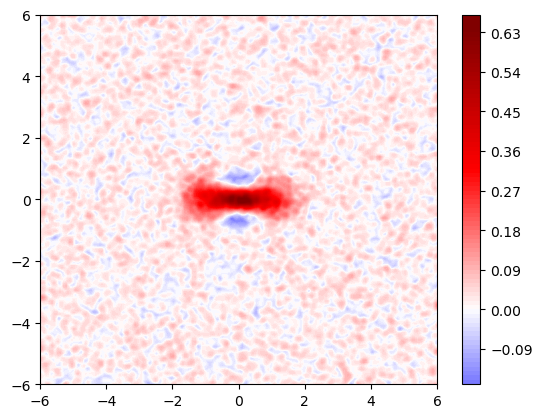

In [17]:
from scipy.ndimage import gaussian_filter

smoothing_sigma = 1.0
wigner_filtered = gaussian_filter(wigner_noisy, sigma=smoothing_sigma)


plot_wigner(xvec, yvec, wigner_filtered)

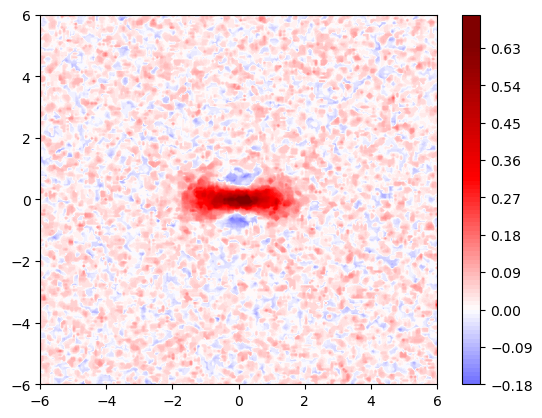

In [16]:
from scipy.ndimage import median_filter

# apply a 3×3 median filter
wigner_med = median_filter(wigner_noisy, size=(3,3))
plot_wigner(xvec, yvec, wigner_med)

### rescale wigner function
